In [1]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import warnings
warnings.simplefilter('ignore')

# Reading the Time Series Data

We will be reading Yahoo's Stock data by usingh the 'web' API provided by Pandas Data Reader. We will be retrieving the Adjusted Close Price and storing it as a Data Frame inside 'data' variable.

In [32]:
data = pd.read_csv("shampoo.csv")

To reduce the variance present inside the data, we will be taking the log of the data. Alternatively, we can also do Box-Cox Transformations as well

In [67]:
# log returns
lsales = np.log(data['Sales']/data['Sales'].shift(1)).dropna()

# Time Series Plot Function

Given below is the function that we'll be using to measure the performance of different time series algorithms applied on the Yahoo Data.

In [35]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize) #defining the figure size
        layout = (3, 2) # Defining the layout having three rows and two columns
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2) #In the first row drawing the time series plot of data
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        
        # In second row drawing the acf and pacf plots of data provided
        acf_ax = plt.subplot2grid(layout, (1, 0)) 
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        
        
        # In the last row providing the QQ Plot and PP Plot
        qq_ax = plt.subplot2grid(layout, (2, 0))
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot') 
        
        pp_ax = plt.subplot2grid(layout, (2, 1))
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        
        plt.tight_layout()
    return 

# Fitting Auto Regressive Model (ARp)

We will use the function "select_order" which will tell us the best value of 'p' based upon the minimum 'aic' values computed.

In [52]:
max_lag = 10
est_order = smt.AR(lsales).select_order(maxlag=max_lag, ic='aic', trend='nc')
mdl = smt.ARMA(lsales, order=(10, 0)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
print('best estimated lag order = {}'.format(est_order))

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   35
Model:                    ARMA(10, 0)   Log Likelihood                   3.528
Method:                           mle   S.D. of innovations              0.204
Date:                Mon, 23 Sep 2019   AIC                             14.945
Time:                        16:21:37   BIC                             32.054
Sample:                             0   HQIC                            20.851
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
ar.L1.Sales     -1.1458      0.176     -6.498      0.000      -1.491      -0.800
ar.L2.Sales     -0.6429      0.246     -2.613      0.015      -1.125      -0.161
ar.L3.Sales     -0.2348      0.255     -0.92

In the below timeseries plot we can see that there are a lot of spikes in acf and pacf plots. Also, the qq and pp plots are heavily weighted at the tails. Moreover, the time series plot of the residual is not similar to a white noise

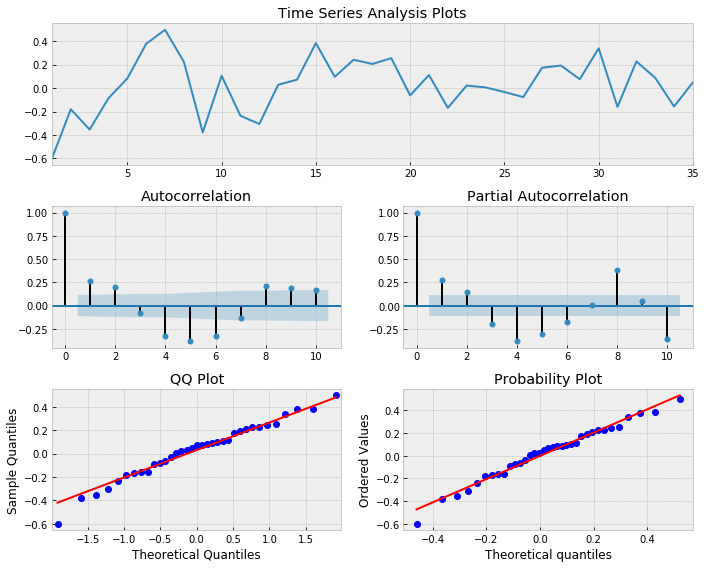

In [53]:
_ = tsplot(mdl.resid, lags=10)

also we can see that the model's aic value is -16396, which is quite large

# Fitting Moving Averages Model (MAq)

We will use the function "select_order" which will tell us the best value of 'q' based upon the minimum 'aic' values computed.

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                   35
Model:                     ARMA(0, 2)   Log Likelihood                  -2.410
Method:                           mle   S.D. of innovations              0.255
Date:                Mon, 23 Sep 2019   AIC                             10.820
Time:                        16:21:57   BIC                             15.486
Sample:                             0   HQIC                            12.431
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ma.L1.Sales    -1.0397      0.257     -4.046      0.000      -1.543      -0.536
ma.L2.Sales     0.4668      0.271      1.720      0.095      -0.065       0.999
                                    Roots       

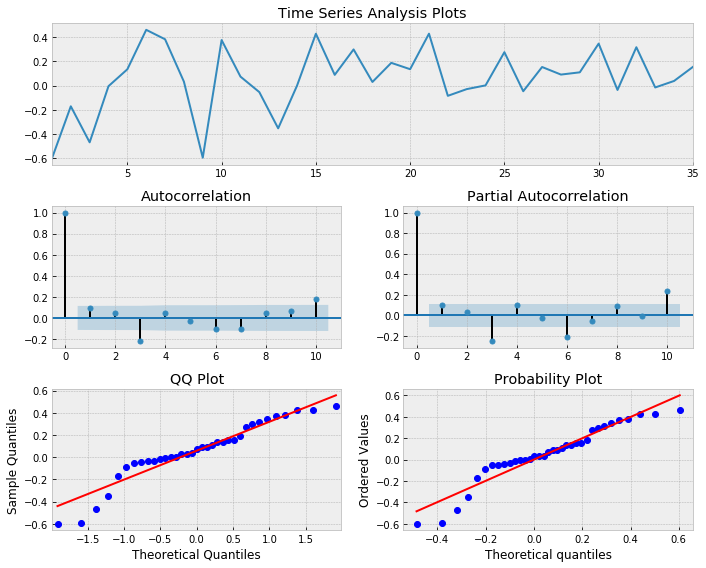

In [54]:
# Fit MA(3) to SPY returns

max_lag = 10
Y = lsales
mdl = smt.ARMA(Y, order=(0, 2)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag)

In the MA model as well we are having the same issues as in the AR model. Hence this is not the best model. We will moce on the look at the combined model

# Fitting ARMA Model

Creating a method which compares different ARMA models' AIC values and then return the best one

We can take any values of p and q to check for the best combinations, but to save time we'll continue with 5

aic: 9.82582 | order: (2, 3)


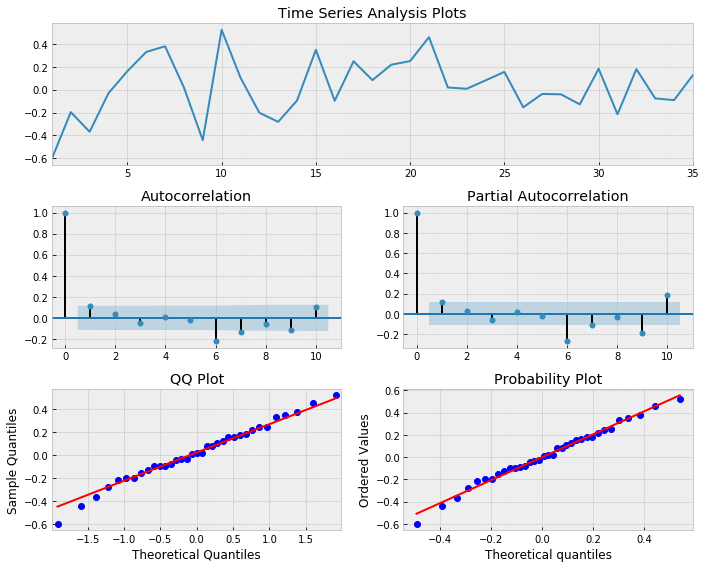

In [55]:
best_aic = np.inf 
best_order = None
best_mdl = None


rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lsales, order=(i, j)).fit(
                method='mle', trend='nc'
            )
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue

_ = tsplot(best_mdl.resid, lags=10)



print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

Even with this model the problem persists and aic has increased even more. Therefore, we will move on to the next model - ARIMA. The best ARMA model that we have got is of order (3,3)

# Fitting ARIMA Model

aic: 9.82582 | order: (2, 0, 3)


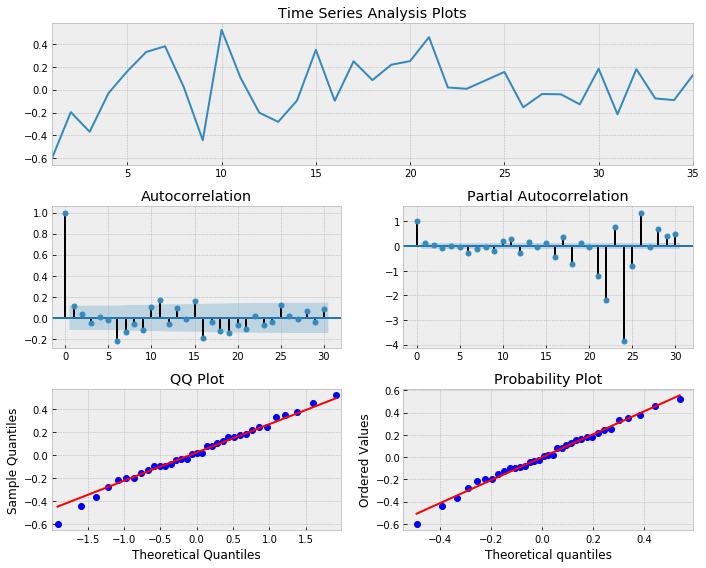

In [56]:
best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(10) # [0,1,2,3,4]
d_rng = range(3) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lsales, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30)

In the above algorithm we got the best order as (3,0,3). As the value of d is coming as 0, thos model is similar to the ARMA model that we saw in the previous cell. That's why the result is also the same.

We can always increase the range to get the better value, if we are ready to sacrifice time

Since the Problem still persists, we can move on to the next method of GARCH. This will help us to check whether the series is having conditional Heteroscedasticity, or we need to make the model better

# GARCH Method

In [43]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lsales
res_tup = _get_best_model(TS)

aic: 9.82582 | order: (2, 0, 3)


We can see that the best model is (4,0,0). With this model the aic value got reduced to -10447.

If we plot the tsplot we can see that the series is much better now and the outcome is similar to white noise.

Still we can confirm whether the model is better or not using GARCH

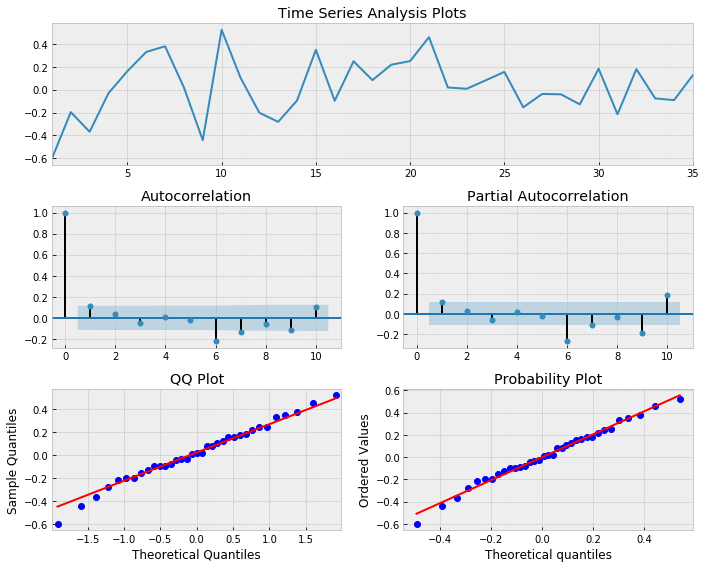

In [51]:
_ = tsplot(res_tup[2].resid, lags=10)

# GARCH Method to check the volatility

After we get out best ARIMA model, we will use the best values of p and q and we'll pass it to the GARCH model to make predictions

In [57]:
p_ = res_tup[1][0]
o_ = res_tup[1][1]
q_ = res_tup[1][2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Sales   R-squared:                      -0.001
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                            GARCH   Log-Likelihood:               -12.3918
Distribution:      Standardized Student's t   AIC:                           40.7835
Method:                  Maximum Likelihood   BIC:                           53.2263
                                              No. Observations:                   35
Date:                      Mon, Sep 23 2019   Df Residuals:                       27
Time:                              16:23:50   Df Model:                            8
                                 Mean Model                                
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
mu     

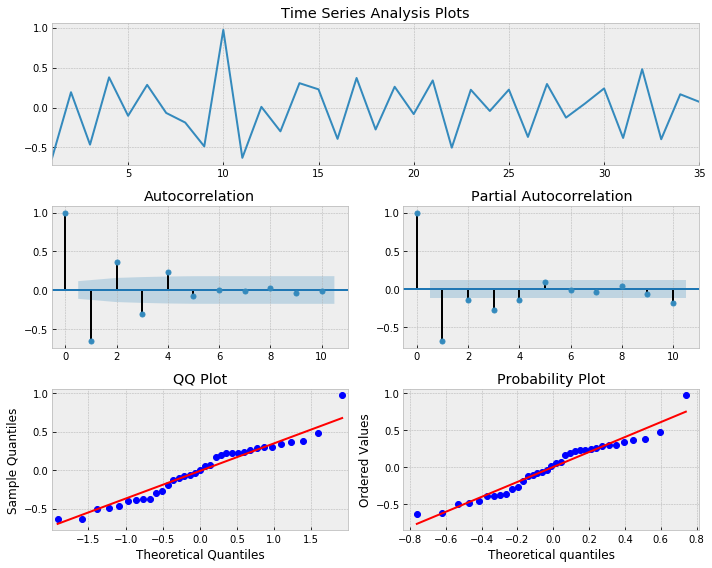

In [58]:
_ = tsplot(res.resid, lags=10)

GARCH gives us the ts plot for variance. We can see that the series is much similar to white noise. Acf and Pacf are both stable, while the heaviness of the tails is also reduced. Therefore, this model is better

# Using GARCH on ARIMA to make forecasts

In [63]:
f = res.forecast(horizon=3)
f.residual_variance.iloc[-1]

h.1    0.072297
h.2    0.104620
h.3    0.120155
Name: 35, dtype: float64